# Import Packages

In [ ]:
import os
import pickle

# To see the progress
from tqdm.notebook import tqdm

import numpy as np

# For visualization
import matplotlib.pyplot as plt

# Things related to the pytorch
import torch                                        # main pytorch package
import torch.nn as nn                               # pytorch module for neural network
from torch.utils.data import Dataset, DataLoader    # pytorch utils for dataset

# Make the dataset! add noise to the linear function
- gt_w, gt_b : ground truth weight and bias for linear regression
- x : random points
- y : gt_w * x + gt_b + (gaussian) noise

In [ ]:
### make the linear dataset. Define the gt_w and gt_b as you want
gt_w = 4.0
gt_b = -2.0

### define the number of data, and value of noise to add to wx+b.
num_data = 1000
noise_value = 2

### Sample some random X between range -1~1
x_range = np.array([-1, 1])
x = np.linspace(x_range[0], x_range[1], num_data)#2 * np.random.rand(num_data) - 1

### Define some noise to add to wx+b
noise = noise_value * np.random.randn(num_data)
y = gt_w * x + gt_b + noise

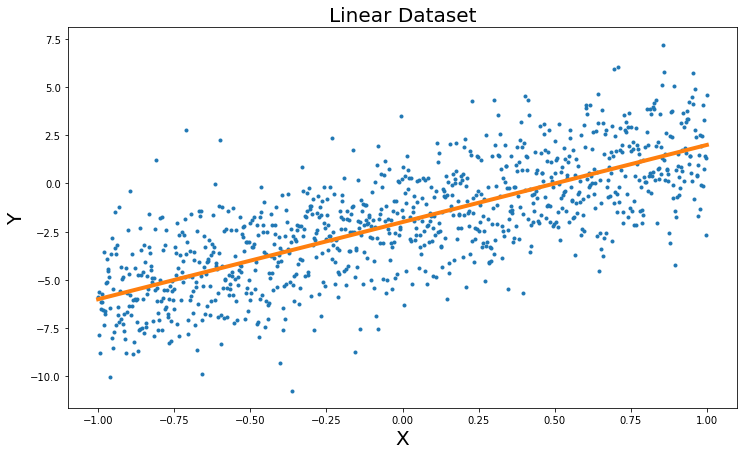

In [ ]:
### Plot the dataset
plt.figure(figsize=(12, 7))
plt.plot(x, y, '.')

### Plot the ground truth linear regressor
plt.plot(x_range, x_range*gt_w+gt_b, linewidth=4)

### Title and extras
plt.title('Linear Dataset', fontsize=20)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.show()

# Define the Pytorch Dataset with x y points
- Define your own class, which inherits from "Dataset" class of pytorch
- Define constructor of the class with init
- Define the length of the dataset with len
- Define the function when bringing out the idx-th dataset
    * Return the dictionary containing the input and output of single datapoint


In [ ]:
class XY_Dataset(Dataset):
    def __init__(self, x, y):
        '''
        x : input points
        y : output points
        '''
        self.x = x
        self.y = y
        self.num_data = x.shape[0]

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        sample = dict()
        sample['x'] = self.x[idx]
        sample['y'] = self.y[idx]

        return sample

# Define the dataset, and dataloader
- DataLoader makes you to randomly sample the dataset with a batch size you want.

In [ ]:
### Define the batch size you want
batch_size = 64

### Create the instance of dataset, and dataloader
dataset = XY_Dataset(x, y)
dataloader = DataLoader(dataset, batch_size, shuffle=True)

### Try sampling out one random data point.
sample = next(iter(dataloader))
print(sample['x'].shape)
print(sample['y'].shape)

torch.Size([64])
torch.Size([64])


# Initialize the weight and bias.

In [ ]:
### Needs requires_grad=True, if you want to make as a parameter to train.
pred_w = torch.randn(1, requires_grad=True)
pred_b = torch.randn(1, requires_grad=True)
print('Initialized w: {}, b: {}'.format(pred_w.item(), pred_b.item()))

Initialized w: 0.9841861724853516, b: -0.3442767560482025


# Define the ,,train'' function. 

In [ ]:
def train(pred_w, pred_b, sample, learning_rate):
    '''
    pred_w : weight to train.
    pred_b : bias to train.
    sample : sample from dataloader. dictionary containing 'x' and 'y'.
    learning_rate : the learning rate you want. 
    pred_loss : predicted loss from this iteration
    '''
    
    # get prediction
    pred_y = pred_w * sample['x'] + pred_b

    # calculate the pred_loss
    criteria = nn.MSELoss()
    pred_loss = criteria(pred_y, sample['y'])
    # pred_loss = torch.norm(pred_y - sample['y']) / len(sample['x'])
    
    # make pytorch compute the gradient
    pred_loss.backward()

    # need ``no_grad'' to keep the computed gradient. otherwise, it will generate NoneType
    with torch.no_grad():
        pred_w -= learning_rate * pred_w.grad
        pred_b -= learning_rate * pred_b.grad

    # initizlize the gradient to zero
    pred_w.grad.zero_()
    pred_b.grad.zero_()   

    return pred_loss

# Iterate over the dataset! With your ,,train'' function

In [ ]:
# define the maximum epoch
max_epoch = 1000

# define a list to save the loss
loss_saver = list()

# define how often you will print the result
print_stride = 50

# iterate over the dataset for (max_epoch) times
for epoch in tqdm(range(max_epoch)):
    total_loss = 0.0
    for idx, sample in enumerate(dataloader):
        pred_loss = train(pred_w, pred_b, sample, learning_rate=0.01)
        total_loss += pred_loss.item()/len(dataloader)

    loss_saver.append(total_loss)
    if epoch % print_stride == 0:
        print('Epoch : {}, Loss : {}, pred_w : {}, pred_b : {}'.format(epoch, total_loss, pred_w.item(), pred_b.item()))

print()
print('Final Prediction : pred_w = {}, pred_b = {}'.format(pred_w.item(), pred_b.item()))

Epoch : 0, Loss : 8.395399328659774, pred_w : 1.292277455329895, pred_b : -0.7782865166664124
Epoch : 50, Loss : 3.66862551896096, pred_w : 3.987197160720825, pred_b : -1.9539036750793457
Epoch : 100, Loss : 3.6865822428231425, pred_w : 3.997896671295166, pred_b : -1.9578102827072144
Epoch : 150, Loss : 3.674054680081812, pred_w : 4.0021891593933105, pred_b : -1.951858639717102
Epoch : 200, Loss : 3.7009284236990596, pred_w : 3.9938173294067383, pred_b : -1.9556790590286255
Epoch : 250, Loss : 3.726586006224482, pred_w : 4.002452850341797, pred_b : -1.9580464363098145
Epoch : 300, Loss : 3.735116348988971, pred_w : 3.99509334564209, pred_b : -1.9497579336166382
Epoch : 350, Loss : 3.7087835302345677, pred_w : 3.997483253479004, pred_b : -1.9500961303710938
Epoch : 400, Loss : 3.69760213343147, pred_w : 3.99599289894104, pred_b : -1.9481905698776245
Epoch : 450, Loss : 3.7106482549782953, pred_w : 3.997673511505127, pred_b : -1.9545021057128906
Epoch : 500, Loss : 3.7012175724573333, pr

# Plot the result : training loss and resulted linear regressor

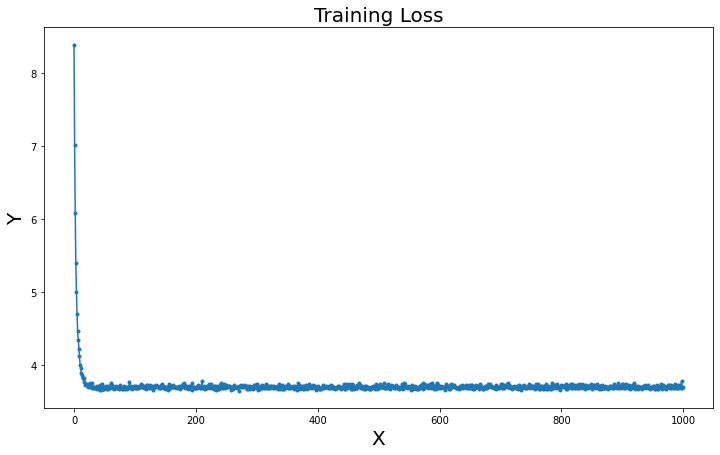

In [ ]:
loss_saver = np.array(loss_saver)
plt.figure(figsize=(12, 7))
plt.plot(np.arange(len(loss_saver)), loss_saver, '.-')
plt.title('Training Loss', fontsize=20)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.show()

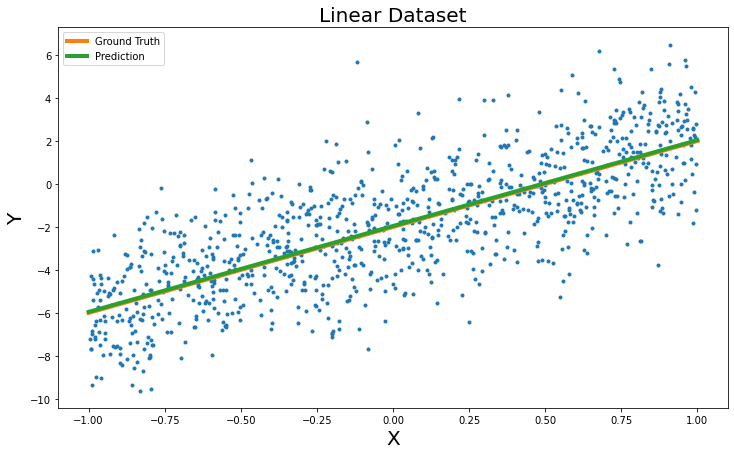

In [ ]:
plt.figure(figsize=(12, 7))

### Plot the dataset
plt.plot(x, y, '.')

### Plot the ground truth + predicted linear regressor
plt.plot(x_range, x_range*gt_w + gt_b, linewidth=4, label='Ground Truth')
plt.plot(x_range, x_range*pred_w.item() + pred_b.item(), linewidth=4, label='Prediction')

### Title and extras
plt.title('Linear Dataset', fontsize=20)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.legend()
plt.show()